# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise') 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [170]:
# Определим две функции для отрисовки сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()
    

Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [3]:
signals = {}

### Единичный импульс

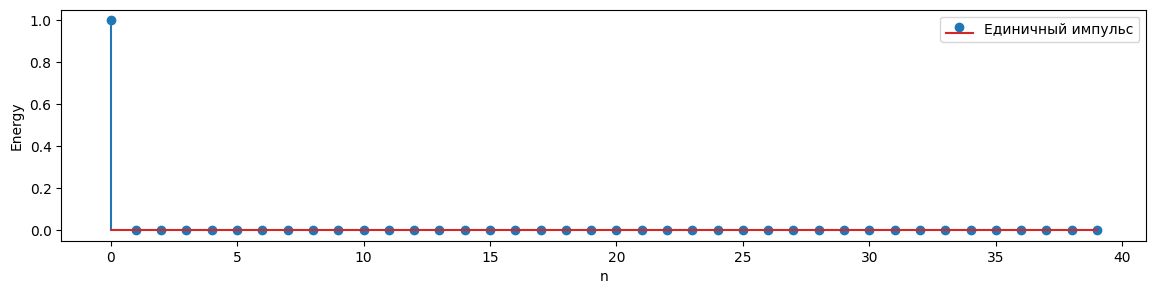

In [105]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

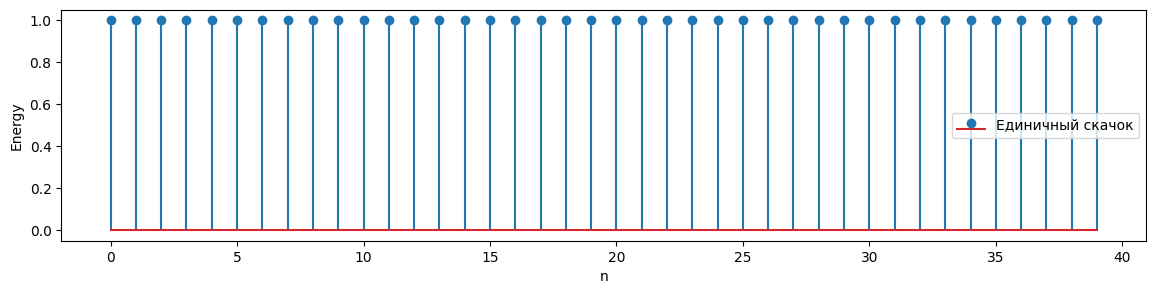

In [56]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float) 
draw_sig(signals[name], name)

### Синус

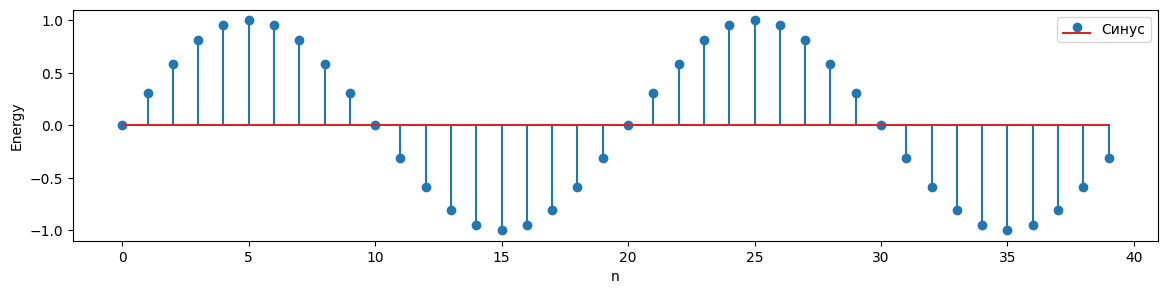

In [59]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

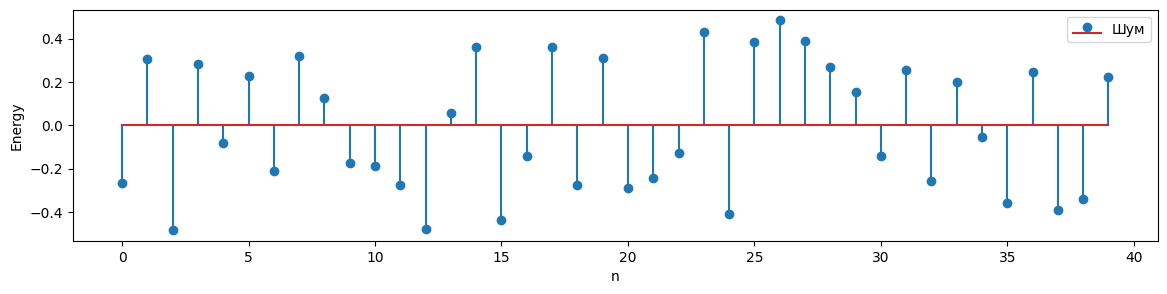

In [58]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье. 
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [60]:
import math

def DFT(x):
    N = len(x)
    result = []
    for k in range(N):
        sum_real = 0
        sum_imag = 0
        for n in range(N):
            angle = 2 * math.pi * k * n / N
            sum_real += x[n] * math.cos(angle)
            sum_imag += -x[n] * math.sin(angle)
        result.append(complex(sum_real, sum_imag))
    return np.array(result)

Сравнение с библиотекой scipy

In [61]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях. 

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [47]:
def FFT(x):
    # YOUR CODE HERE
    

    raise NotImplementedError()

In [ ]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [ ]:
# YOUR CODE HERE

# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости. 
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [62]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    return np.array([math.sqrt(c.real**2 + c.imag**2) for c in spec])

#функция построения фазового спектра
def get_phi_from_spec(spec):
    return np.array([math.atan2(c.imag, c.real) for c in spec])

In [63]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"

    
_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."

   
print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [64]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо, 
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot
    
    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
        
    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return 

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице? 
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый? 
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

Рисуем спектры для Единичный импульс


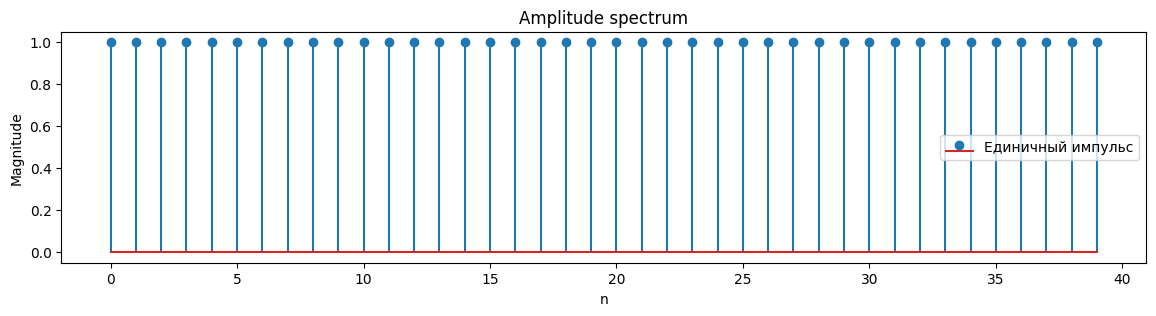

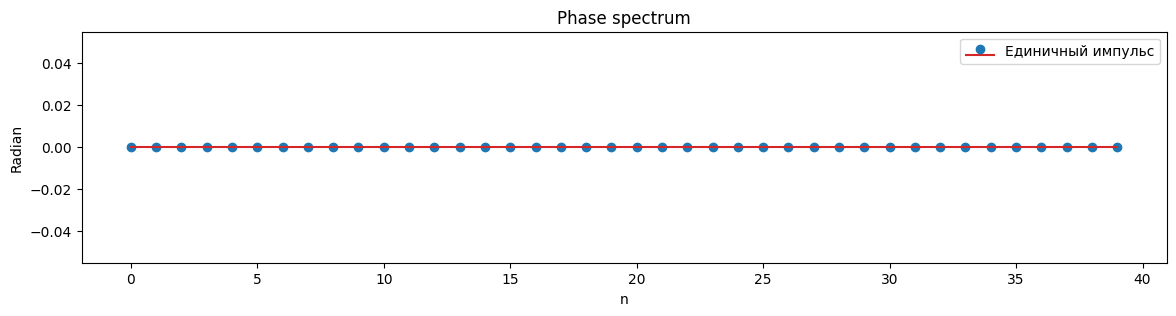

Рисуем спектры для Единичный скачок


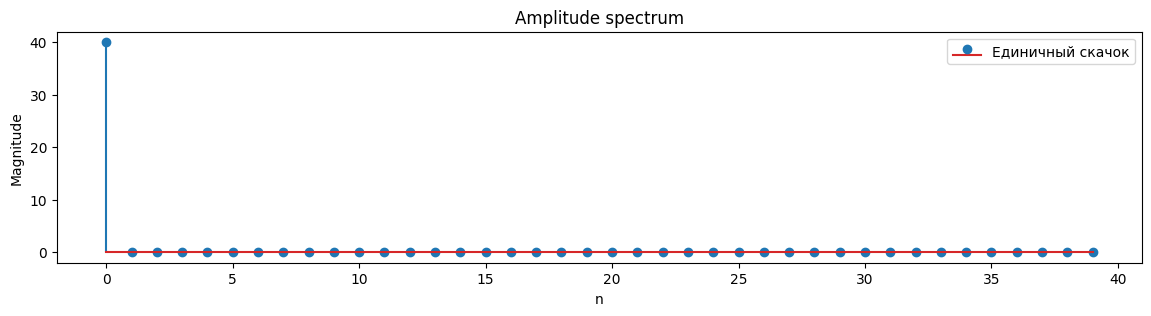

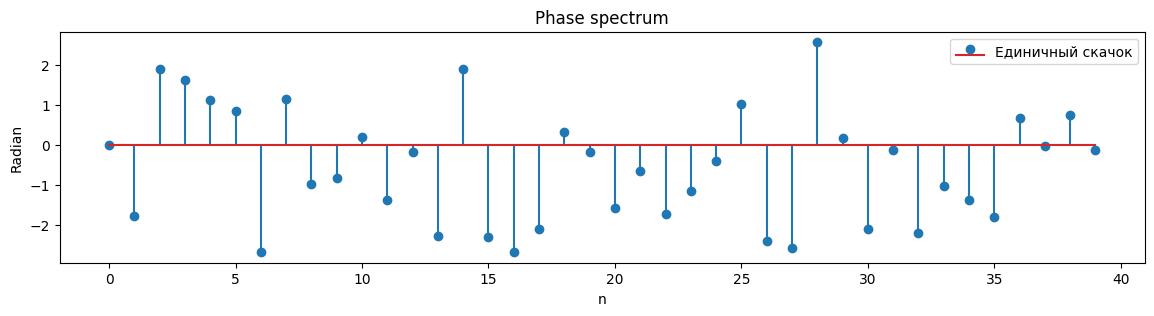

Рисуем спектры для Синус


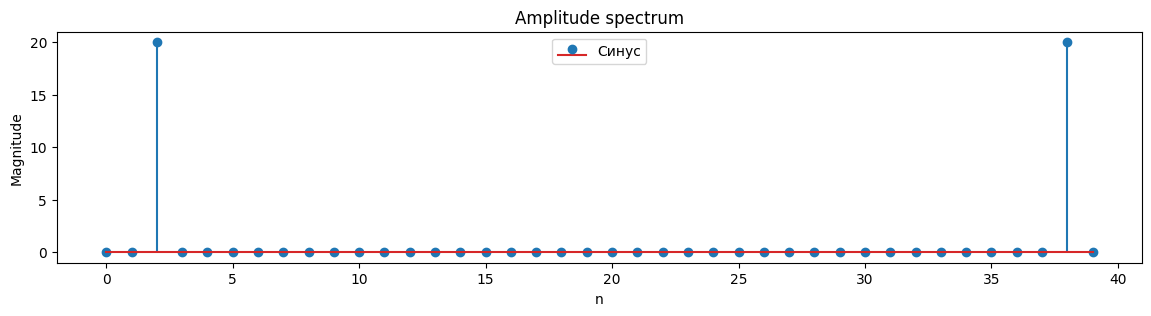

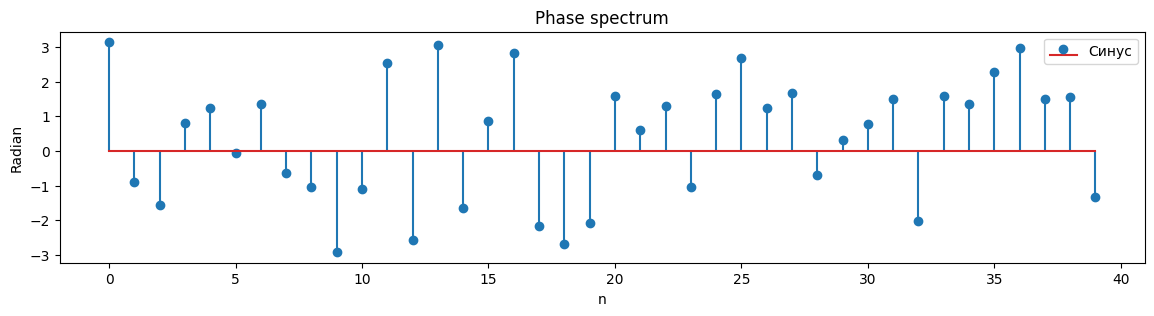

Рисуем спектры для Шум


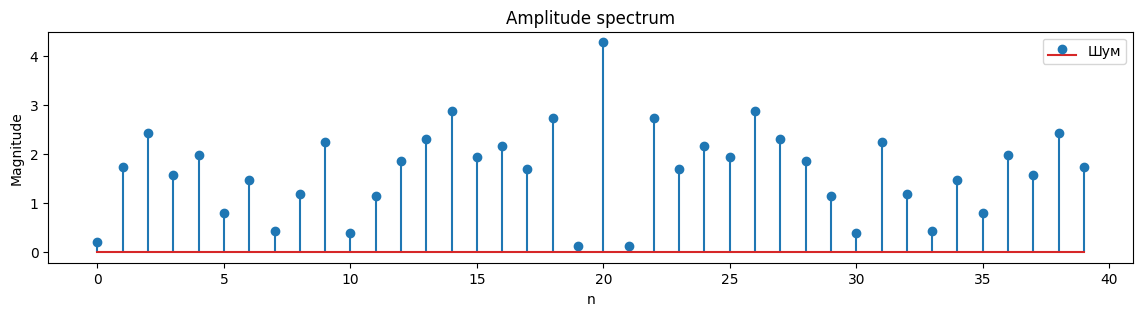

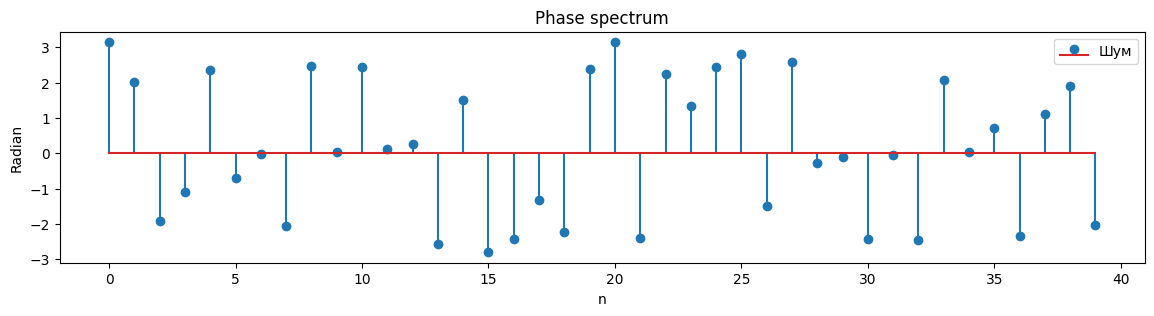

In [65]:
for name, signal in signals.items():
    print(f"Рисуем спектры для {name}")
    spec = DFT(signal)
    draw_spec(spec, name=name)

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

Для импульса верно: `x[n] = 1` только при `n = 0`. После применения DFT мы получаем $X[k] = \sum_0^{N-1} x[n] \cdot e^{-i2\pi kn / N}$.

Подставим значения `x[n]` и получим, что слагаемое не зануляется только при `n=0`. Значит, $\forall k :  X[k] = 1 \cdot e^{-i2\pi k \cdot 0 / N} = 1$.

Это мы и видим на полученном спектре.

In [ ]:
# ANSWER ABOVE

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

1. Единичный импульс.
    1. Амплитудный спектр: Все частоты представлены одинаково, потому что единичный импульс содержит все частоты.
    2. Фазовый спектр: Нулевая фаза на всех частотах, так как нет сдвига фаз.
2. Единичный скачок.
    1. Амплитудный спектр: Сильный пик на частоте `n=0`, что соответствует постоянной составляющей сигнала. Остальные частоты не вносят вклад, амплитуда равна нулю для остальных гармоник. Это объясняется тем, что единичный скачок — это сигнал с постоянным значением, которое не изменяется во времени, что соответствует чистой постоянной составляющей в частотной области.
    2. Фазовый спектр: В нуле фаза равна нулю, что соответствует постоянной составляющей без сдвига фазы. На остальных частотах хаотичные значения. Возможно из-за того, что в начальной точке было резкое изменение сигнала.
3. Синусоида.
    1. Амплитудный спектр: Два пика на определённой частоте (основная гармоника). Пики: один — положительная частота, другой — отрицательная частота в спектре.
    2. Фазовый спектр: Фаза изменяется хаотично на различных частотах. Однако на частотах, соответствующих основным гармоникам, фаза фиксирована (модуль одинаков, но знаки разные).
4. Шум.
    1. Амплитудный спектр: Разбросанный спектр, покрывающий широкий диапазон частот.
    2. Фазовый спектр: Случайный, отражает непериодичность и хаотичность сигнала.

In [ ]:
# ANSWER ABOVE

### 3. Как перевести номер отсчета в частоту?

В DFT частоты дискретизируются, и каждой частоте $f_n$ соответствует определённый индекс $n$ в спектре. 

Перевести одно в другое можно по формуле $f_n = \frac{n \cdot f_s}{N}$, где $f_s$ -- частота дискретизации, а $N$ -- количество отсчетов ($n \in [0, N-1]$).

In [ ]:
# ANSWER ABOVE

### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

Полезная информация:
1. Фаза гармоник, связанных с сигналом. Фазовый сдвиг для частот, соответствующих основным составляющим сигнала (пики в амплитудном спектре) является полезной информацией. Он указывает на то, как сигнал смещён во времени относительно начала отсчёта.
2. Симметрия фаз. Для реальных сигналов фазы обычно симметричны относительно середины спектра (отрицательные и положительные частоты). Это тоже может быть полезным, поскольку подтверждает реальность сигнала и отсутствие артефактов обработки.
3. Фазовая связь между частотами. Иногда сигналы состоят из нескольких частотных компонентов, которые имеют фазовую связь между собой. Эта связь определяет форму сигнала во временной области.

Шумы:
1. Фаза на частотах с незначительной амплитудой. Фазовая информация на тех частотах, где амплитуда очень мала или близка к нулю, чаще всего является случайной и не несёт полезной информации. В этих частотах сигнал не содержит значимой энергии, и любые изменения фазы являются артефактами численных методов или шумов в данных.
2. Хаотические изменения фазы. Если фаза изменяется хаотически и не связана с основными компонентами сигнала, то это тоже связано с шумом.

In [ ]:
# ANSWER ABOVE

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [166]:
from scipy.signal import get_window

def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size 
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram 
    
    win = get_window(window, n_fft)
    
    num_segments = len(x) // hop_length + 1
    
    stft_matrix = np.zeros((n_fft // 2 + 1, num_segments), dtype=np.complex64)

    x = np.concatenate([[0] * (n_fft // 2), x, [0] * (n_fft // 2)])

    for i in range(num_segments):
        start = i * hop_length
        end = start + n_fft
        segment = x[start:end]
        
        segment_windowed = segment * win
        
        fft_result = np.fft.rfft(segment_windowed, n=n_fft)
        
        stft_matrix[:, i] = fft_result
    
    return stft_matrix
    

In [167]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1 
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0
        
for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


Определим функцию для отрисовки

In [168]:
# Определим функцию для отрисовки
def draw_stft(X, sr, figsize=(14, 5)):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма 
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты. 


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


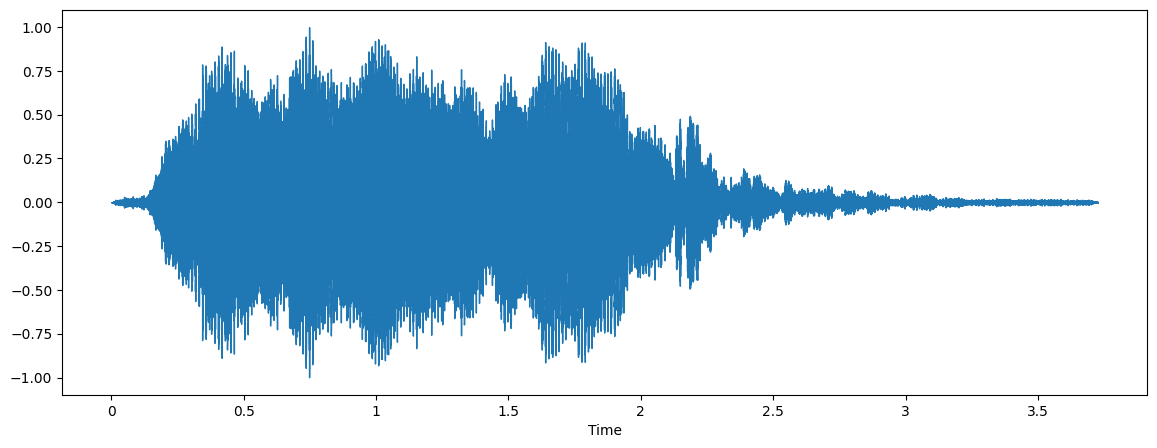

In [171]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources/train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


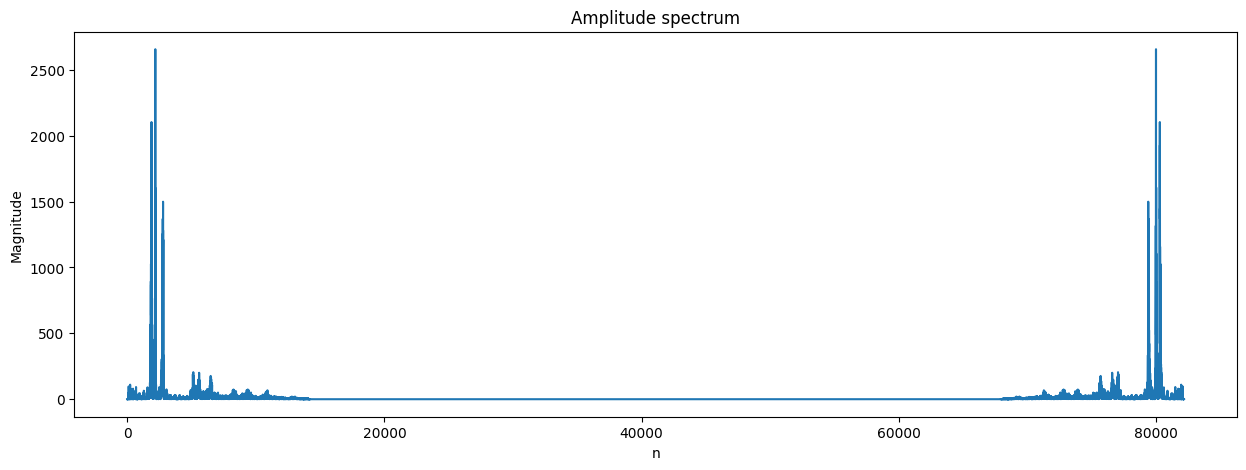

In [179]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

In [237]:
a = get_amplitude_from_spec(spec=train_whistle_spec)[:len(train_whistle_spec)//2]
a_sorted = sorted(list(enumerate(a)), key=lambda x: x[1], reverse=True)

def get_freq(h):
    return (h * tw_sr) / len(train_whistle)

print(a_sorted[:20])

[(2183, np.float64(2656.20104660773)), (2179, np.float64(2329.0483034922227)), (2180, np.float64(2123.3339351124214)), (1885, np.float64(2103.3686077337943)), (2182, np.float64(2080.654944963244)), (1886, np.float64(2021.3464571913446)), (1879, np.float64(1927.0664882146646)), (1880, np.float64(1909.5080518290567)), (2169, np.float64(1607.036869521045)), (1884, np.float64(1603.1559499936368)), (1887, np.float64(1511.777678761001)), (2785, np.float64(1499.0151767076943)), (1892, np.float64(1486.43432414621)), (1891, np.float64(1466.3841583977917)), (2784, np.float64(1460.1905697545099)), (1875, np.float64(1446.8827267612257)), (1881, np.float64(1443.1973184564888)), (2171, np.float64(1396.530164371683)), (2172, np.float64(1376.8071306468455)), (1876, np.float64(1369.02743763593))]


### 1 гармоника

In [238]:
h1 = 2183
print(np.round(get_freq(h1), 2))

585.76


### 2 гармоника

In [239]:
h2 = 1885
print(np.round(get_freq(h2), 2))

505.8


### 3 гармоника

In [240]:
h3 = 2785
print(np.round(get_freq(h3), 2))

747.3


### Тест

In [243]:
# task_answer = [ freq1, freq2, freq3 ]
task_answer = [585.76, 505.8, 747.3]

In [244]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")       

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

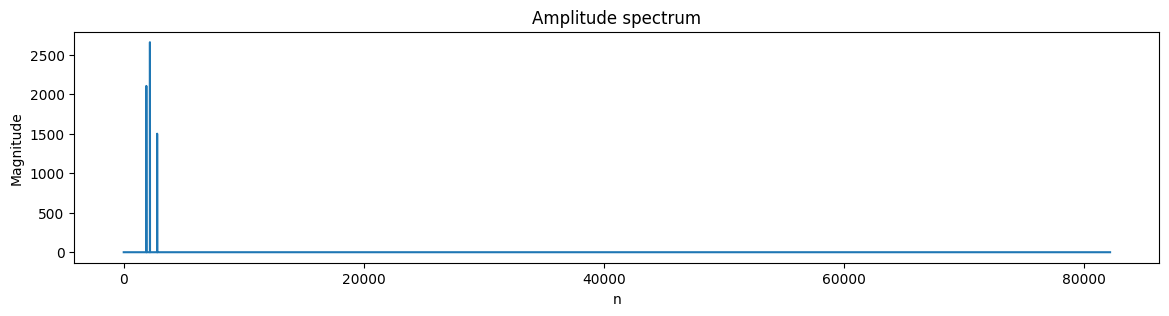

In [253]:
frequences = np.fft.fftfreq(len(train_whistle), d=1/tw_sr)
mask = np.isin(np.round(frequences, 1), np.round(task_answer, 1))
res = np.fft.ifft(train_whistle_spec * mask)
player = ipd.Audio(res, rate=tw_sr)
ipd.display(player)
draw_spec(train_whistle_spec * mask, draw_p=False)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера. 

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


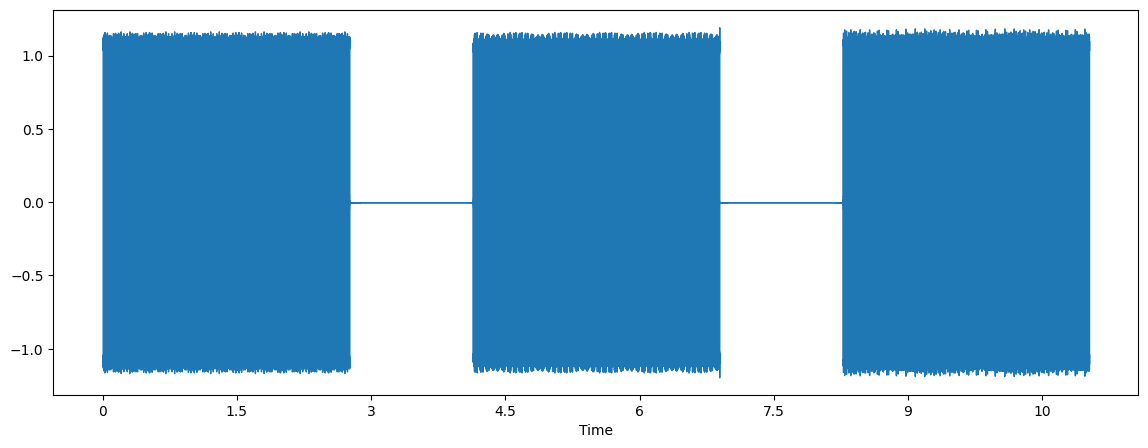

In [254]:
#dtmf.wav
dtmf, dtmf_sr = librosa.core.load("resources/dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

In [264]:
dtmf_spec = STFT(dtmf, tw_sr, tw_sr)
a = np.array([get_amplitude_from_spec(spec) for spec in dtmf_spec])
print(a.argmax(axis=0)[:20])

[ 697  697  697 1209  770 1336 1336  770  852 1477 1477 1477]


### 1 число

In [266]:
# 697, 1209
print(1)

1


### 2 число

In [267]:
# 770, 1336
print(5)

5


### 3 число

In [268]:
# 852, 1477
print(9)

9


### Тест

In [270]:
# phone_number = [first: int, second: int, third: int]
phone_number = [1, 5, 9]

In [271]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")   

Correct!
